# Machine Learning - Practicum 5
<b>Student:</b> Justin Klein<br>
<b>Nummer:</b> 1707815

In [1]:
import ssl
import tensorflow as tf
import tensorflow.keras.datasets.cifar10 as cifar
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Data Analysis and Preparation
Eerst laden we de cifar10 data in en verdelen we de data die gebruikt wordt voor het trainen en testen in hun bijbehorende variabelen.

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
data = cifar.load_data()

In [3]:
train_data = data[0]
test_data = data[1]

print(f"Length of train_data feature records: {len(train_data[0])}, and target records: {len(train_data[1])}")
print(f"Length of test_data feature records: {len(test_data[0])}, and target records: {len(test_data[1])}")

Length of train_data feature records: 50000, and target records: 50000
Length of test_data feature records: 10000, and target records: 10000


Nu verdelen we de features en targets in nieuwe variabelen zodat we het kunnen gebruiken in een CNN. De features normalizeren we en voor de targets gebruiken we one-hot encoding.

In [4]:
X_train_data = train_data[0] / 255
X_test_data = test_data[0] / 255

y_train_data = utils.to_categorical(train_data[1], 10)
y_test_data = utils.to_categorical(test_data[1], 10)

Nu zien we dat de data goed ingedeeld is in variabelen en dat de data de juiste input dimensies heeft voor het CNN.

In [5]:
print(f"Size of a picture in X_train is: {len(X_train_data[0])}x{len(X_train_data[0][0])}")
print(f"Size of a picture in X_test is: {len(X_test_data[0])}x{len(X_test_data[0][0])}")

Size of a picture in X_train is: 32x32
Size of a picture in X_test is: 32x32


## Modelling CNN
Nu kunnen we het convolutionele netwerk bouwen. Voor het netwerk had ik in de eerste instantie gekozen voor twee convolutionele layers met maxpools (leNet), maar dit gaf nog niet het gewenste resultaat (~0.65 accuracy). Ik heb evenveel filters gekozen als de breedte van de hoeveelheid pixels, dit bleek een goed startpunt te zijn. Toen ik meer layers toevoegde voor iedere pool zag ik de accuracy omhoog gaan (van 0.65 naar 0.75). Dit heb ik vervolgens ge-fine-tuned en vaak getest tot ik bij de juiste hoeveelheid layers, filters en filter-groottes kwam. Toen ik padding toevoegde gaf dat nog iets meer nauwkeurigheid. De maxPooling heb ik op 2x2 gehouden en de strides op (2,2) gezet aangezien het een beter resultaat gaf dan de default stride (1,1). Uiteindelijk heb ik gekozen voor een FC layer van 512 dense nodes en een dropout layer (20%). Ik koos voor 512 nodes aangezien meer dan 512 het netwerk trager maakte en het er ook minder nauwkeurig van werdt. Minder dan 512 nodes maakt het netwerk sneller maar ook minder nauwkeurig. 

In [6]:
model = Sequential()

# ========== Convolution Layer + Pool ==========
model.add(Conv2D(filters=32, padding='same', kernel_size=(3, 3), input_shape=(32,32,3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(filters=32, padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


# ========== Convolution Layer + Pool ==========
model.add(Conv2D(filters=64, padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(filters=64, padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(filters=64, padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


# ========== Convolution Layer + Pool + Flattening ==========
model.add(Conv2D(filters=128, padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(filters=128, padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model.add(Flatten())


# ========== FC Layers + Dropout ==========
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))


Vervolgens ziet het netwerk er zo uit:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

Nu compilen we het netwerk, en omdat we met one-hot encodig werken gebruiken we 'categorical_crossentropy' en ik heb de 'adam' optimizer gekozen voor een kortere trainingstijd.

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the Model
Nu we het model hebben opgesteld gaan we het model trainen met de trainingsdata. Ik heb simpelweg de batch_size op 32 gelaten (default) en de hoeveelheid epochs op 7, want meer dan 15 leidt tot een overfit model. Ik gebruik de waardes uit de test_data als validatiedata wat later in de grafiek gebruikt kan worden voor de visualisatie.

In [9]:
training = model.fit(X_train_data, y_train_data, batch_size=32, epochs=7, verbose=1, validation_data=(X_test_data, y_test_data))

Epoch 1/7
1563/1563 [==============================] - 19s 11ms/step - loss: 1.6936 - accuracy: 0.4079 - val_loss: 1.3066 - val_accuracy: 0.5238
Epoch 2/7
1563/1563 [==============================] - 16s 11ms/step - loss: 1.1149 - accuracy: 0.6012 - val_loss: 1.0765 - val_accuracy: 0.6312
Epoch 3/7
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8929 - accuracy: 0.6865 - val_loss: 1.0874 - val_accuracy: 0.6287
Epoch 4/7
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7583 - accuracy: 0.7362 - val_loss: 0.8598 - val_accuracy: 0.7144
Epoch 5/7
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6578 - accuracy: 0.7760 - val_loss: 0.7364 - val_accuracy: 0.7556
Epoch 6/7
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5692 - accuracy: 0.8053 - val_loss: 0.6229 - val_accuracy: 0.7951
Epoch 7/7
1563/1563 [==============================] - 16s 11ms/step - loss: 0.4953 - accuracy: 0.8324 - val_loss: 0.6047 - val_ac

We zien dat hier een hoge accuracy gehaald wordt. Het is dus nu tijd om het op de testset uit te voeren om de uiteindelijke accuracy te berekenen.

## Testing the Model

In [10]:
loss, accuracy = model.evaluate(X_test_data, y_test_data)
print(f"Model loss: {loss:.4f} | Model accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.6047 - accuracy: 0.7982
Model loss: 0.6047 | Model accuracy: 0.7982


### Graph
Nu we de accuracy en loss hebben bepaald kunnen we dit het beste in een grafiek weergeven door de accuracy en de nauwkeurigheid van de actuele waardes van de output naast elkaar te leggen.

313/313 - 1s - loss: 0.6047 - accuracy: 0.7982


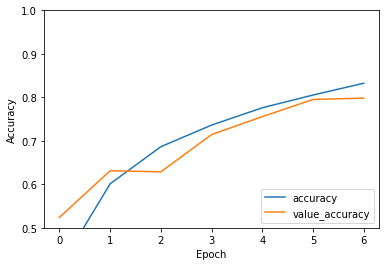

In [11]:
plt.plot(training.history['accuracy'], label='accuracy')
plt.plot(training.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_data,  y_test_data, verbose=2)

## Conclusie
Uit de accuracy en loss zien we dat het model een zeer aardig resultaat behaalt. In ongeveer 4/5 gevallen zijn de voorspellingen correct. Het model is ook niet overfit, want we zien dat in de grafiek de lijn van de actuele accuracy op de train set en de validation_accuracy op de testset heel dicht bij elkaar liggen en elkaar zelfs kruisen. Het model zelf is zeer effectief, omdat het model (desondanks de hoeveelheid layers) maar ongeveer 2 minuten nodig heeft om volledig te trainen (7 epochs). Kortom, het model werkt goed en is effectief. 